In [1]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY

## Example Hardware

Validating System platform: MTL...
System platform is valid!


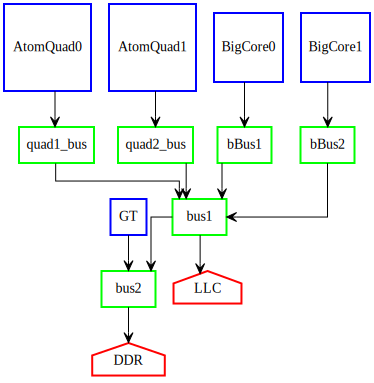

In [2]:
PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.01).instance
a_clk = Clock("a_clk", 0.01)    # 10 ns
b_clk = Clock("b_clk", 0.01)    # 10 ns
g_clk = Clock("g_clk", 0.01)    # 10 ns
sys_platform.add_clock(clk)
sys_platform.add_clock(a_clk)
sys_platform.add_clock(b_clk)
sys_platform.add_clock(g_clk)

# IPs:
# - Ports
# - Drivers
# - Executing units

# Atoms
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)
    
# Big cores
bCores = dict()
for i in range(2):
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    ex_u = ExecutingUnit("ex_u", b_clk, 1)

    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)

# GT 
gt_p = Port('p')
gt_dr = Driver('dr', g_clk)
gt_ex = ExecutingUnit('ex_u', g_clk)

gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)

# IP Buses
quad1_bus = Bus('quad1_bus', clk, 64)
quad2_bus = Bus('quad2_bus', clk, 64)
bBus1 = Bus('bBus1', clk, 64)
bBus2 = Bus('bBus2', clk, 64)
sys_platform.add_bus(quad1_bus)
sys_platform.add_bus(quad2_bus)
sys_platform.add_bus(bBus1)
sys_platform.add_bus(bBus2)

# System buses
bus1 = Bus('bus1', clk, 64)
bus2 = Bus('bus2', clk, 64)
sys_platform.add_bus(bus1)
sys_platform.add_bus(bus2)

# Memories
llc = Memory('LLC', clk, 1024)
ddr = Memory('DDR', clk, 1024)
sys_platform.add_memory(llc)
sys_platform.add_memory(ddr)

# Connecting
sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad1_bus)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad2_bus)

sys_platform.connect_to_bus(bCores["BigCore0"][1], bBus1)
sys_platform.connect_to_bus(bCores["BigCore1"][1], bBus2)

sys_platform.connect_to_bus(bBus1, bus1)
sys_platform.connect_to_bus(bBus2, bus1)
sys_platform.connect_to_bus(quad1_bus, bus1)
sys_platform.connect_to_bus(quad2_bus, bus1)
sys_platform.connect_to_bus(bus1, bus2)

sys_platform.connect_to_memory(bus1, llc)
sys_platform.connect_to_memory(bus2, ddr)
sys_platform.connect_to_bus(gt_p, bus2)

sys_platform.validate_platform()
sys_platform

In [3]:
from pnets.plotting import interval_graph
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

## Custom scheduler
### schedules every task by its map type

In [4]:
from asap.schedulers import BaseSystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState
from collections import namedtuple

class AtomFirstScheduler:
    """
    Atom first scheduler:
        prefer tasks that should be mapped to resource of type core to atoms first with penalty, if all atoms are busy then map to CPU
    """
    def __init__(self, system_mgr, properties):
        self._system_mgr = system_mgr
        self._base_scheduler = BaseSystemScheduler(self._system_mgr)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]
        
    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips
    
    def schedule_task(self, task, resource):
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._base_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._base_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        else:
            return self._base_scheduler.schedule_task(task, list())
    
    def on_task_finish(self, task):
        self._base_scheduler.on_task_finish(task)

# Task graph
## Usage of multiple memories:
### Attach attribute MappingDesc.Memory_Targets to each task with dictionary: {memory name: percent of data, .. }
### In the example: core tasks -> 50% DDR 50% LLC, gt tasks -> 100% DDR

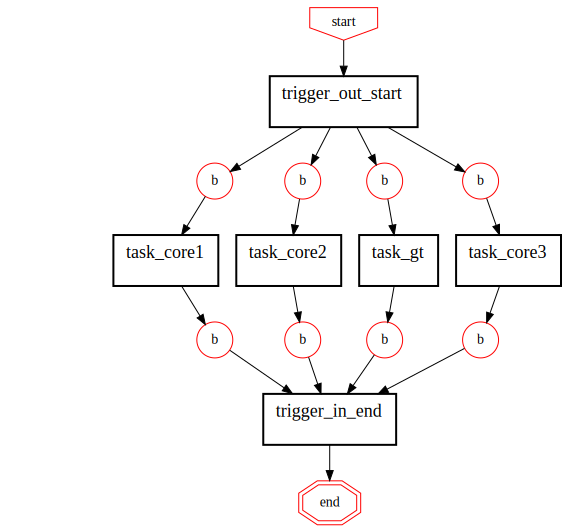

In [5]:
from asap.workload import Workload, Task, Connection, TYPES
from asap.mapping import Mapping
from asap.strings import MappingDesc

wl = Workload('abstract')
m = Mapping('mapping', wl)

start = Task('start', TYPES.START)
wl.add_task(start)
# Lev1
j1 = Task('end', TYPES.END)
wl.add_task(j1)
t = Task('task_core1', type=TYPES.READ, read_bytes=10240)
t.attach_attribute(MappingDesc.MEMORY_TARGETS, {'DDR': 50, 'LLC': 50})
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('1', t, j1)
wl.connect_tasks('2', start, t)
t = Task('task_core2', type=TYPES.WRITE, write_bytes=10000)
t.attach_attribute(MappingDesc.MEMORY_TARGETS, {'DDR': 50, 'LLC': 50})
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('3', t, j1)
wl.connect_tasks('4', start, t)
t = Task('task_gt', type=TYPES.WRITE, write_bytes=3000)
t.attach_attribute(MappingDesc.MEMORY_TARGETS, {'DDR': 100})
t.attach_attribute('MAP_TYPE', 'GT')
wl.add_task(t)
wl.connect_tasks('5', t, j1)
wl.connect_tasks('6', start, t)
t = Task('task_core3', type=TYPES.WRITE, write_bytes=10000)
t.attach_attribute(MappingDesc.MEMORY_TARGETS, {'DDR': 50, 'LLC': 50})
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('13', t, j1)
wl.connect_tasks('14', start, t)


pnml_model = wl.to_pnml_model()
pnml_model

# Results with multi memory extension

In [6]:
from speedsim import SpeedSim
from models.fabric.multi_memory import MultiMemoryExtension

sys_platform.reset()
speedsim = SpeedSim(sys_platform, wl, m)
speedsim.set_system_scheduler(AtomFirstScheduler)
speedsim.add_extension('MultiMemory', MultiMemoryExtension)
res = speedsim.simulate(1000000)

res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.0,0.703125,task_gt,GT/dr,0,0.703125
1,0.0,4.687500,task_core2,AtomQuad1/driver,0,4.687500
2,0.0,4.687500,task_core3,BigCore0/driver,0,4.687500
3,0.0,4.725000,task_core1,AtomQuad0/driver,0,4.725000


In [7]:
clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['AtomQuad0/ex_u{}'.format(i) for i in range(4)] + ['AtomQuad1/ex_u{}'.format(i) for i in range(4)] + ['BigCore0__ex_u', 'BigCore1__ex_u'] + ['GT/ex_u']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)

## Analysis of the multi memory results
### table - runtime, res - residency of interval scope

In [8]:
from post_processing.utils import get_hw_analysis, AnalysisData
from asap.strings import ResourceDesc

ip_table, ip_res = get_hw_analysis(ResourceDesc.IP, start=0, end=None, intervals=1)
memory_table, memory_res = get_hw_analysis(ResourceDesc.MEMORY, 0)
bus_table, bus_res = get_hw_analysis(ResourceDesc.BUS, 0)
ip_res

,0.00-4.72
GT/dr,14.880952
AtomQuad1/driver,99.206349
BigCore0/driver,99.206349
AtomQuad0/driver,100.000000


In [9]:
memory_res

,0.00-4.72
DDR,100.0
LLC,100.0
